# Safe, Robust & Explainable RL Agent
## Integrated Project — Phase 5 + Phase 6 of the RL Roadmap

**Author:** Abdullah Zahid  
**LinkedIn:** [linkedin.com/in/abdullahzahid655](https://linkedin.com/in/abdullahzahid655)  
**GitHub:** [github.com/abdullahzahid655](https://github.com/abdullahzahid655)

---

## Project Overview

This notebook is the companion project for **Phase 5 (Advanced RL Paradigms)** and **Phase 6 (Safety, Robustness & Explainability)** of our LinkedIn RL Roadmap series.

We build **one unified RL agent** on `CartPole-v1` (extended with a safety cost) and layer on:

| Component | Phase | Technique |
|-----------|-------|-----------|
| Baseline Agent | 1-4 | Standard DQN |
| Offline Pre-training | Phase 5 | Behaviour Cloning from logged data |
| Safety Constraints | Phase 6 | PPO-Lagrangian (CMDP) |
| Robustness | Phase 6 | Adversarial Observation Training (SA-DQN) |
| Explainability | Phase 6 | SHAP + Policy Distillation into Decision Tree |

### Environment: Safe CartPole
- **Reward:** +1 per timestep (maximize survival)
- **Safety Cost:** +1 when `|pole_angle| > 0.15 rad` -> budget `b = 20` per episode
- **Goal:** Maximize reward while keeping cost <= budget


## Section 1: Setup & Installation


In [ ]:
import os
import sys
import subprocess
from pathlib import Path

# Configuration
VENV_NAME = "rl_phase6_env"
VENV_PATH = Path.home() / VENV_NAME

def create_venv():
    """Create virtual environment if it doesn't exist."""
    if VENV_PATH.exists():
        print(f"✅ Virtual environment '{VENV_NAME}' already exists at:")
        print(f"   {VENV_PATH}")
        return False
    else:
        print(f"📦 Creating new virtual environment '{VENV_NAME}'...")
        subprocess.check_call([sys.executable, '-m', 'venv', str(VENV_PATH)])
        print(f"✅ Virtual environment created at: {VENV_PATH}")
        return True

def get_venv_python():
    """Get path to Python executable in virtual environment."""
    if os.name == 'nt':  # Windows
        return VENV_PATH / 'Scripts' / 'python.exe'
    else:  # Linux/Mac
        return VENV_PATH / 'bin' / 'python'

def install_packages(python_exe):
    """Install all required packages in virtual environment."""
    print("\n📦 Installing packages in virtual environment...")
    
    packages = [
        'ipykernel',          # Required for Jupyter
        'ipywidgets',
        'numpy==1.24.3',
        'scipy==1.10.1',
        'torch',
        'gymnasium',
        'matplotlib',
        'seaborn',
        'scikit-learn',
        'pandas',
        'tqdm',
        'shap==0.42.1',
    ]
    
    for pkg in packages:
        print(f"   Installing {pkg}...", end=' ')
        subprocess.check_call(
            [str(python_exe), '-m', 'pip', 'install', pkg, '-q'],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
        print("✓")
    
    print("\n✅ All packages installed!")

def register_kernel(python_exe):
    """Register the virtual environment as a Jupyter kernel."""
    print("\n🔧 Registering Jupyter kernel...")
    subprocess.check_call([
        str(python_exe), '-m', 'ipykernel', 'install',
        '--user',
        '--name', VENV_NAME,
        '--display-name', f'Python (RL Phase 6)'
    ])
    print(f"✅ Kernel 'Python (RL Phase 6)' registered!")

# Main execution
print("="*70)
print("🚀 RL Phase 6 Environment Setup")
print("="*70)

newly_created = create_venv()
venv_python = get_venv_python()

if newly_created:
    # Fresh install
    install_packages(venv_python)
    register_kernel(venv_python)
    print("\n" + "="*70)
    print("✅ SETUP COMPLETE!")
    print("="*70)
    print("\n📋 NEXT STEPS:")
    print("1. Go to: Kernel → Change Kernel")
    print("2. Select: 'Python (RL Phase 6)'")
    print("3. Run Cell 2 (imports)")
    print("="*70)
else:
    # Environment exists - check if packages are installed
    print("\n🔍 Checking if packages are installed...")
    try:
        result = subprocess.run(
            [str(venv_python), '-c', 'import shap; import numpy; print(numpy.__version__)'],
            capture_output=True,
            text=True,
            timeout=5
        )
        if result.returncode == 0:
            print(f"✅ Packages already installed! NumPy version: {result.stdout.strip()}")
            print("\n📋 NEXT STEPS:")
            print("1. Go to: Kernel → Change Kernel")
            print("2. Select: 'Python (RL Phase 6)'")
            print("3. Run Cell 2 (imports)")
        else:
            print("⚠️  Packages missing. Installing now...")
            install_packages(venv_python)
            register_kernel(venv_python)
            print("\n✅ Packages installed! Switch kernel as instructed above.")
    except Exception as e:
        print(f"⚠️  Error checking packages: {e}")
        print("   Re-installing packages...")
        install_packages(venv_python)
        register_kernel(venv_python)

print("\n💡 TIP: If you don't see the kernel, restart Jupyter and try again.")

🚀 RL Phase 6 Environment Setup
✅ Virtual environment 'rl_phase6_env' already exists at:
   /home/test/rl_phase6_env

🔍 Checking if packages are installed...
✅ Packages already installed! NumPy version: 1.24.3

📋 NEXT STEPS:
1. Go to: Kernel → Change Kernel
2. Select: 'Python (RL Phase 6)'
3. Run Cell 2 (imports)

💡 TIP: If you don't see the kernel, restart Jupyter and try again.


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
import shap
import random
from collections import deque, namedtuple
from tqdm import trange
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## Section 2: Safe CartPole Environment (Phase 6 — Safety)

We extend standard CartPole with a **safety cost signal** to create a CMDP:
- `cost = 1` when `|pole_angle| > 0.15 rad`
- Safety budget per episode: `b = 20`

**Math:** CMDP objective: max J^r s.t. J^c <= b


In [2]:
class SafeCartPoleEnv:
    """
    Safe CartPole - CMDP wrapper.
    Adds a cost signal: cost=1 if |pole_angle| > COST_THRESHOLD.
    Phase 6: Safety component of the integrated project.
    """
    COST_THRESHOLD = 0.15  # radians

    def __init__(self, render_mode=None, noise_std=0.0):
        self.env = gym.make('CartPole-v1', render_mode=render_mode)
        self.noise_std = noise_std
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space
        self.episode_cost = 0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.episode_cost = 0
        return self._add_noise(obs), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        pole_angle = obs[2]
        cost = 1.0 if abs(pole_angle) > self.COST_THRESHOLD else 0.0
        self.episode_cost += cost
        info['cost'] = cost
        info['episode_cost'] = self.episode_cost
        return self._add_noise(obs), reward, terminated, truncated, info

    def _add_noise(self, obs):
        if self.noise_std > 0:
            obs = obs + np.random.normal(0, self.noise_std, obs.shape)
        return obs.astype(np.float32)

    def close(self):
        self.env.close()


env_test = SafeCartPoleEnv()
obs, _ = env_test.reset(seed=SEED)
print('State features: [cart_pos, cart_vel, pole_angle, pole_vel]')
print('State shape:', obs.shape)
print('Safety cost threshold: +-0.15 rad')
env_test.close()
print('Environment created successfully!')


State features: [cart_pos, cart_vel, pole_angle, pole_vel]
State shape: (4,)
Safety cost threshold: +-0.15 rad
Environment created successfully!


## Section 3: Neural Network Architectures


In [3]:
class QNetwork(nn.Module):
    """Standard DQN Q-network. Input: state (4-dim), Output: Q-values (2 actions)."""
    def __init__(self, state_dim=4, action_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.net(x)


class DualQNetwork(nn.Module):
    """
    Dual Q-Network for Safe RL (Phase 6).
    Returns Q_reward and Q_cost separately.
    Used in Lagrangian-based CMDP optimisation.
    """
    def __init__(self, state_dim=4, action_dim=2, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU()
        )
        self.reward_head = nn.Linear(hidden_dim, action_dim)
        self.cost_head   = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        f = self.encoder(x)
        return self.reward_head(f), self.cost_head(f)


Transition = namedtuple('Transition', ['state','action','reward','cost','next_state','done'])

class ReplayBuffer:
    def __init__(self, capacity=50_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, c, s2, d):
        self.buffer.append(Transition(np.array(s,dtype=np.float32), a, r, c,
                                      np.array(s2,dtype=np.float32), d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return (
            torch.FloatTensor([t.state for t in batch]).to(device),
            torch.LongTensor([t.action for t in batch]).to(device),
            torch.FloatTensor([t.reward for t in batch]).to(device),
            torch.FloatTensor([t.cost for t in batch]).to(device),
            torch.FloatTensor([t.next_state for t in batch]).to(device),
            torch.FloatTensor([t.done for t in batch]).to(device)
        )

    def __len__(self):
        return len(self.buffer)


print('QNetwork, DualQNetwork, ReplayBuffer defined.')
print(f'  QNetwork params: {sum(p.numel() for p in QNetwork().parameters()):,}')


QNetwork, DualQNetwork, ReplayBuffer defined.
  QNetwork params: 17,410


## Section 4: Phase 5 — Offline Pre-training via Behaviour Cloning

**Offline RL (Phase 5):** Collect a dataset from a heuristic policy, then pre-train
the Q-network via Behaviour Cloning — **zero environment interaction** during training.

This is the Phase 5 concept: learn from a fixed, pre-collected dataset.


Dataset size: 12,470 transitions

Phase 5: Behaviour Cloning Pre-training...
  BC Epoch 10/30: loss=0.4426
  BC Epoch 20/30: loss=0.4281
  BC Epoch 30/30: loss=0.4262


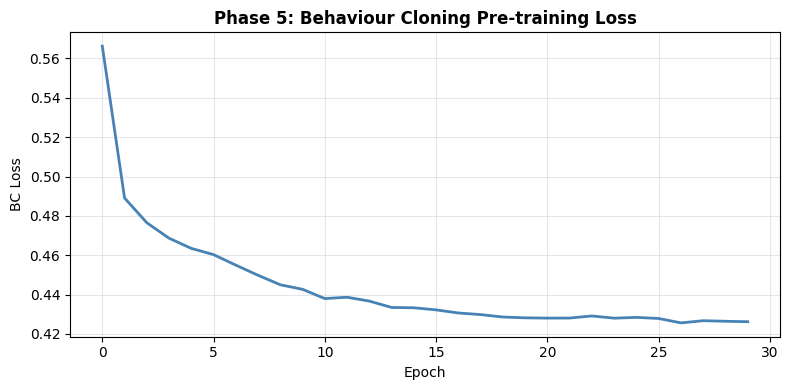

BC pre-training complete!


In [4]:
def collect_offline_dataset(n_episodes=300):
    """Collect offline data from 70% heuristic + 30% random policy."""
    env, dataset = SafeCartPoleEnv(), []
    for ep in range(n_episodes):
        obs, _ = env.reset(seed=ep)
        done = False
        while not done:
            action = (1 if obs[2] > 0 else 0) if random.random() < 0.7 else env.action_space.sample()
            nobs, rew, term, trunc, info = env.step(action)
            done = term or trunc
            dataset.append((obs.copy(), action, rew, info['cost'], nobs.copy(), float(done)))
            obs = nobs
    env.close()
    return dataset


def behaviour_cloning_pretrain(data, n_epochs=30, batch_size=128, lr=1e-3):
    """Phase 5 Offline RL: imitate dataset actions with cross-entropy loss."""
    model = QNetwork().to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    states  = torch.FloatTensor([d[0] for d in data]).to(device)
    actions = torch.LongTensor([d[1] for d in data]).to(device)
    N, losses = len(states), []
    for epoch in range(n_epochs):
        idx = torch.randperm(N)
        ep_loss = 0.0
        for start in range(0, N, batch_size):
            bi = idx[start:start+batch_size]
            loss = F.cross_entropy(model(states[bi]), actions[bi])
            opt.zero_grad(); loss.backward(); opt.step()
            ep_loss += loss.item()
        losses.append(ep_loss / (N / batch_size))
        if (epoch+1) % 10 == 0:
            print(f'  BC Epoch {epoch+1}/{n_epochs}: loss={losses[-1]:.4f}')
    return model, losses


print('Collecting offline dataset...')
offline_data = collect_offline_dataset(300)
print(f'Dataset size: {len(offline_data):,} transitions')
print('\nPhase 5: Behaviour Cloning Pre-training...')
bc_model, bc_losses = behaviour_cloning_pretrain(offline_data, n_epochs=30)

plt.figure(figsize=(8,4))
plt.plot(bc_losses, color='steelblue', lw=2)
plt.xlabel('Epoch'); plt.ylabel('BC Loss')
plt.title('Phase 5: Behaviour Cloning Pre-training Loss', fontweight='bold')
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
print('BC pre-training complete!')


## Section 5: Baseline DQN Agent (fine-tuned from BC weights)


In [7]:
class DQNAgent:
    GAMMA=0.99; LR=1e-3; BATCH=64; TAU=0.005
    EPS_START=1.0; EPS_END=0.05; EPS_DECAY=0.995

    def __init__(self, pretrained=None):
        self.policy = QNetwork().to(device)
        self.target = QNetwork().to(device)
        if pretrained:
            self.policy.load_state_dict(pretrained.state_dict())
            print('  Loaded BC pre-trained weights (Phase 5 Offline RL)')
        self.target.load_state_dict(self.policy.state_dict())
        self.target.eval()
        self.opt = optim.Adam(self.policy.parameters(), lr=self.LR)
        self.mem = ReplayBuffer(); self.eps = self.EPS_START

    def act(self, s):
        if random.random() < self.eps: return random.randint(0,1)
        with torch.no_grad():
            return self.policy(torch.FloatTensor(s).unsqueeze(0).to(device)).argmax().item()

    def update(self):
        if len(self.mem) < self.BATCH: return
        s,a,r,c,s2,d = self.mem.sample(self.BATCH)
        q = self.policy(s).gather(1,a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            t = r + self.GAMMA * self.target(s2).max(1)[0] * (1-d)
        loss = F.smooth_l1_loss(q, t)
        self.opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
        self.opt.step()
        for p,pt in zip(self.policy.parameters(), self.target.parameters()):
            pt.data.copy_(self.TAU*p.data + (1-self.TAU)*pt.data)
        self.eps = max(self.EPS_END, self.eps*self.EPS_DECAY)


def train_dqn(agent, n_eps=400, label='DQN'):
    env = SafeCartPoleEnv()
    rew_hist, cost_hist = [], []
    for ep in trange(n_eps, desc=f'Training {label}'):
        obs, _ = env.reset(); ep_r, ep_c, done = 0, 0, False
        while not done:
            a = agent.act(obs)
            nobs, r, term, trunc, info = env.step(a)
            done = term or trunc
            agent.mem.push(obs, a, r, info['cost'], nobs, float(done))
            agent.update()
            ep_r += r; ep_c += info['cost']; obs = nobs
        rew_hist.append(ep_r); cost_hist.append(ep_c)
    env.close()
    return rew_hist, cost_hist


print('Training Baseline DQN (with BC pre-training from Phase 5)...')
dqn_agent = DQNAgent(pretrained=bc_model)
dqn_rewards, dqn_costs = train_dqn(dqn_agent, n_eps=400, label='Baseline DQN')
print(f'Final 50-ep mean reward: {np.mean(dqn_rewards[-50:]):.1f}')
print(f'Final 50-ep mean cost:   {np.mean(dqn_costs[-50:]):.1f}')


Training Baseline DQN (with BC pre-training from Phase 5)...
  Loaded BC pre-trained weights (Phase 5 Offline RL)


Training Baseline DQN: 100%|██████████| 400/400 [05:37<00:00,  1.18it/s]

Final 50-ep mean reward: 62.0
Final 50-ep mean cost:   53.0


## Section 6: Phase 6 — Safe RL with Lagrangian Method

**CMDP Objective:**
```
max J^r  subject to  J^c <= b
```
Implemented via dual variable (Lagrange multiplier) lambda:
```
Q_safe(s,a) = Q_reward(s,a) - lambda * Q_cost(s,a)
```
Lambda adapts automatically: increases when cost > budget, decreases when cost < budget.

**Paper:** Achiam et al. (2017) CPO — ICML


In [8]:
class SafeDQNAgent:
    """
    Phase 6: Safe DQN with Lagrangian CMDP.
    Maintains two Q-heads (reward + cost) and a learnable lambda.
    """
    GAMMA=0.99; LR_Q=1e-3; LR_LAG=0.01; BATCH=64
    COST_BUDGET=20.0; TAU=0.005
    EPS_START=0.5; EPS_END=0.05; EPS_DECAY=0.997

    def __init__(self):
        self.net    = DualQNetwork().to(device)
        self.target = DualQNetwork().to(device)
        self.target.load_state_dict(self.net.state_dict()); self.target.eval()
        self.opt     = optim.Adam(self.net.parameters(), lr=self.LR_Q)
        self.mem     = ReplayBuffer()
        self.log_lam = torch.tensor(0.0, requires_grad=True, device=device)
        self.lag_opt = optim.Adam([self.log_lam], lr=self.LR_LAG)
        self.eps = self.EPS_START; self.lam_hist = []

    @property
    def lam(self): return F.softplus(self.log_lam)

    def act(self, s):
        if random.random() < self.eps: return random.randint(0,1)
        with torch.no_grad():
            t = torch.FloatTensor(s).unsqueeze(0).to(device)
            qr, qc = self.net(t)
            return (qr - self.lam * qc).argmax().item()

    def update(self, cost_avg=None):
        if len(self.mem) < self.BATCH: return
        s,a,r,c,s2,d = self.mem.sample(self.BATCH)
        qr,qc = self.net(s)
        qra = qr.gather(1,a.unsqueeze(1)).squeeze(1)
        qca = qc.gather(1,a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            qrn,qcn = self.target(s2)
            ba = (qrn - self.lam*qcn).argmax(1,keepdim=True)
            tr = r + self.GAMMA*qrn.gather(1,ba).squeeze(1)*(1-d)
            tc = c + self.GAMMA*qcn.gather(1,ba).squeeze(1)*(1-d)
        loss = F.smooth_l1_loss(qra,tr) + self.lam.detach()*F.smooth_l1_loss(qca,tc)
        self.opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(),10); self.opt.step()
        if cost_avg is not None:
            ll = -self.lam*(cost_avg - self.COST_BUDGET)
            self.lag_opt.zero_grad(); ll.backward(); self.lag_opt.step()
        for p,pt in zip(self.net.parameters(),self.target.parameters()):
            pt.data.copy_(self.TAU*p.data+(1-self.TAU)*pt.data)
        self.eps = max(self.EPS_END, self.eps*self.EPS_DECAY)


print('Phase 6: Training Safe DQN (Lagrangian CMDP)...')
safe_agent = SafeDQNAgent()
env_s = SafeCartPoleEnv()
safe_rewards, safe_costs, lambdas = [], [], []
recent = deque(maxlen=20)

for ep in trange(400, desc='Safe DQN'):
    obs,_ = env_s.reset(); ep_r,ep_c,done = 0,0,False
    while not done:
        a = safe_agent.act(obs)
        nobs,r,term,trunc,info = env_s.step(a)
        done=term or trunc
        safe_agent.mem.push(obs,a,r,info['cost'],nobs,float(done))
        safe_agent.update(cost_avg=float(np.mean(recent)) if recent else 0.0)
        ep_r+=r; ep_c+=info['cost']; obs=nobs
    recent.append(ep_c)
    safe_rewards.append(ep_r); safe_costs.append(ep_c)
    lambdas.append(safe_agent.lam.item())

env_s.close()
print(f'Final 50-ep mean reward: {np.mean(safe_rewards[-50:]):.1f}')
print(f'Final 50-ep mean cost:   {np.mean(safe_costs[-50:]):.1f}')
print(f'Final lambda:            {lambdas[-1]:.4f}')


Phase 6: Training Safe DQN (Lagrangian CMDP)...


Safe DQN: 100%|██████████| 400/400 [06:06<00:00,  1.09it/s]

Final 50-ep mean reward: 143.8
Final 50-ep mean cost:   12.7
Final lambda:            0.0043


## Section 7: Phase 6 — Robust DQN (SA-DQN Adversarial Training)

Implements a simplified **SA-DQN** (Zhang et al., NeurIPS 2020):
- FGSM attack perturbs observations during training
- Regularisation loss forces consistency between clean and adversarial Q-values
- Result: policy robust to worst-case observation noise at deployment


In [9]:
class RobustDQNAgent:
    """
    Phase 6: Robust DQN with adversarial training (SA-DQN concept).
    FGSM perturbs observations; robustness regulariser added to loss.
    """
    GAMMA=0.99; LR=1e-3; BATCH=64; TAU=0.005
    EPS_ADV=0.05; ADV_ALPHA=0.5
    EPS_GREEDY=0.3; EPS_MIN=0.05; EPS_DECAY=0.997

    def __init__(self):
        self.policy = QNetwork().to(device)
        self.target = QNetwork().to(device)
        self.target.load_state_dict(self.policy.state_dict()); self.target.eval()
        self.opt = optim.Adam(self.policy.parameters(), lr=self.LR)
        self.mem = ReplayBuffer(); self.eps = self.EPS_GREEDY

    def fgsm(self, s):
        s_adv = s.clone().detach().requires_grad_(True)
        loss = -self.policy(s_adv).max(1)[0].sum()
        loss.backward()
        return (s + self.EPS_ADV * s_adv.grad.sign()).detach()

    def act(self, s):
        if random.random() < self.eps: return random.randint(0,1)
        with torch.no_grad():
            return self.policy(torch.FloatTensor(s).unsqueeze(0).to(device)).argmax().item()

    def update(self):
        if len(self.mem) < self.BATCH: return
        s,a,r,c,s2,d = self.mem.sample(self.BATCH)
        q  = self.policy(s).gather(1,a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            tgt = r + self.GAMMA*self.target(s2).max(1)[0]*(1-d)
        loss_clean  = F.smooth_l1_loss(q, tgt)
        s_adv       = self.fgsm(s)
        loss_robust = F.mse_loss(self.policy(s_adv), self.policy(s).detach())
        loss = loss_clean + self.ADV_ALPHA * loss_robust
        self.opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(),10); self.opt.step()
        for p,pt in zip(self.policy.parameters(),self.target.parameters()):
            pt.data.copy_(self.TAU*p.data+(1-self.TAU)*pt.data)
        self.eps = max(self.EPS_MIN, self.eps*self.EPS_DECAY)


print('Phase 6: Training Robust DQN (SA-DQN)...')
robust_agent = RobustDQNAgent()
env_r = SafeCartPoleEnv()
robust_rewards, robust_costs = [], []

for ep in trange(400, desc='Robust DQN'):
    obs,_ = env_r.reset(); ep_r,ep_c,done = 0,0,False
    while not done:
        a = robust_agent.act(obs)
        nobs,r,term,trunc,info = env_r.step(a)
        done=term or trunc
        robust_agent.mem.push(obs,a,r,info['cost'],nobs,float(done))
        robust_agent.update()
        ep_r+=r; ep_c+=info['cost']; obs=nobs
    robust_rewards.append(ep_r); robust_costs.append(ep_c)

env_r.close()
print(f'Final 50-ep mean reward: {np.mean(robust_rewards[-50:]):.1f}')


Phase 6: Training Robust DQN (SA-DQN)...


Robust DQN: 100%|██████████| 400/400 [01:07<00:00,  5.92it/s]

Final 50-ep mean reward: 13.3


## Section 8: Phase 6 — Explainable RL with SHAP

**SHAP (Shapley Additive explanations)** applied to the Q-network:
- Decomposes Q-value decisions into per-feature contributions
- phi_i > 0 means feature i pushed the Q-value up
- Based on: Beechey et al. (2023) ICML


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Collected 4,799 state observations
Computing SHAP values (approx 30 seconds)...


100%|██████████| 300/300 [00:11<00:00, 26.20it/s]


SHAP values computed!


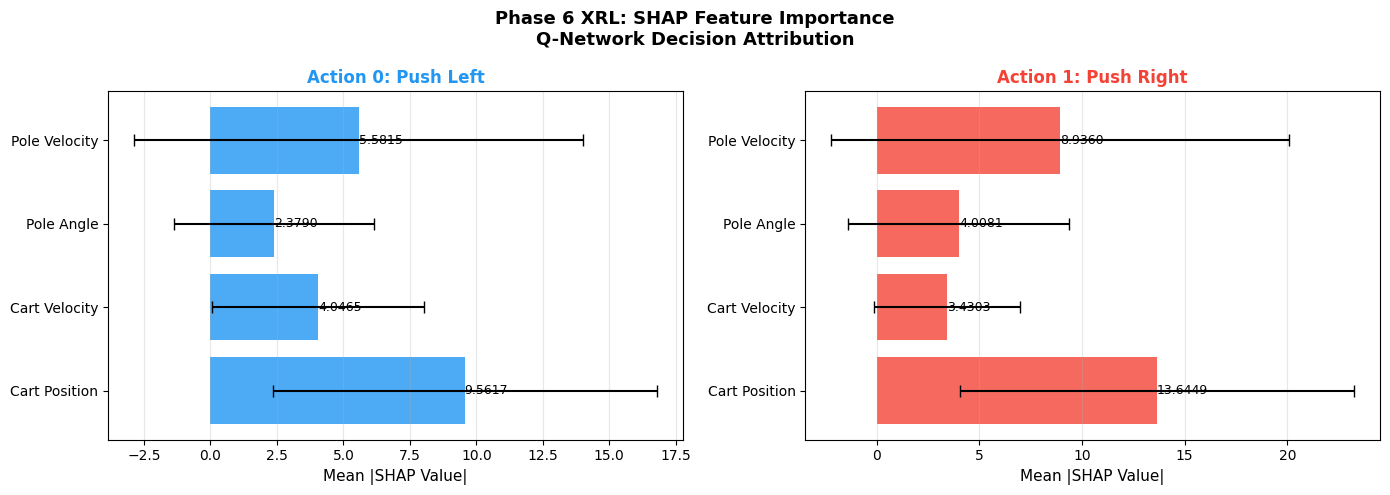

Most influential feature: Cart Position


In [10]:
def collect_states(agent, n_eps=80):
    env = SafeCartPoleEnv(); states = []
    for ep in range(n_eps):
        obs,_ = env.reset(seed=ep); done=False
        while not done:
            states.append(obs.copy())
            obs,_,t,tr,_ = env.step(agent.act(obs)); done=t or tr
    env.close()
    return np.array(states, dtype=np.float32)


print('Collecting states for SHAP analysis...')
shap_states = collect_states(dqn_agent, n_eps=80)
print(f'Collected {len(shap_states):,} state observations')

feature_names = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity']

def q_fn(x):
    with torch.no_grad():
        return dqn_agent.policy(torch.FloatTensor(x).to(device)).cpu().numpy()

bg   = shap_states[np.random.choice(len(shap_states), 200, replace=False)]
test = shap_states[np.random.choice(len(shap_states), 300, replace=False)]

print('Computing SHAP values (approx 30 seconds)...')
explainer   = shap.KernelExplainer(q_fn, bg)
shap_values = explainer.shap_values(test, nsamples=80)
print('SHAP values computed!')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Phase 6 XRL: SHAP Feature Importance\nQ-Network Decision Attribution',
             fontsize=13, fontweight='bold')

for i, (ax, lbl, col) in enumerate(zip(
    axes,
    ['Action 0: Push Left', 'Action 1: Push Right'],
    ['#2196F3', '#F44336']
)):
    sv = shap_values[i]
    means = np.abs(sv).mean(0)
    stds  = np.abs(sv).std(0)
    bars  = ax.barh(feature_names, means, xerr=stds, color=col, alpha=0.8, capsize=4)
    for b, v in zip(bars, means):
        ax.text(v+0.001, b.get_y()+b.get_height()/2, f'{v:.4f}', va='center', fontsize=9)
    ax.set_xlabel('Mean |SHAP Value|', fontsize=11)
    ax.set_title(lbl, fontsize=12, fontweight='bold', color=col)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=130, bbox_inches='tight')
plt.show()
top_feat = feature_names[np.argmax(np.abs(shap_values[0]).mean(0) + np.abs(shap_values[1]).mean(0))]
print(f'Most influential feature: {top_feat}')


## Section 9: Phase 6 — Policy Distillation into Decision Tree

Distil the DNN policy into a **human-readable decision tree**:
1. Generate large dataset of (state, DNN-action) pairs
2. Fit a DecisionTreeClassifier
3. Fidelity = how well the tree matches the DNN
4. Print IF-THEN rules for full transparency


Distillation data: 100%|██████████| 300/300 [00:09<00:00, 33.28it/s]


Dataset: 17,905 samples


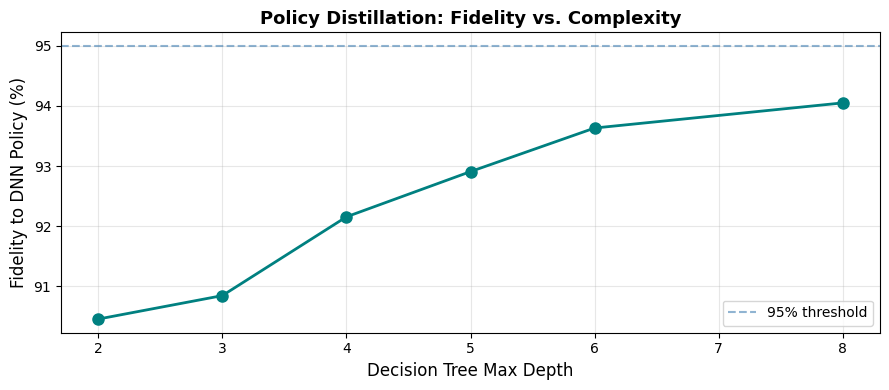

Depth-4 tree fidelity: 92.2%


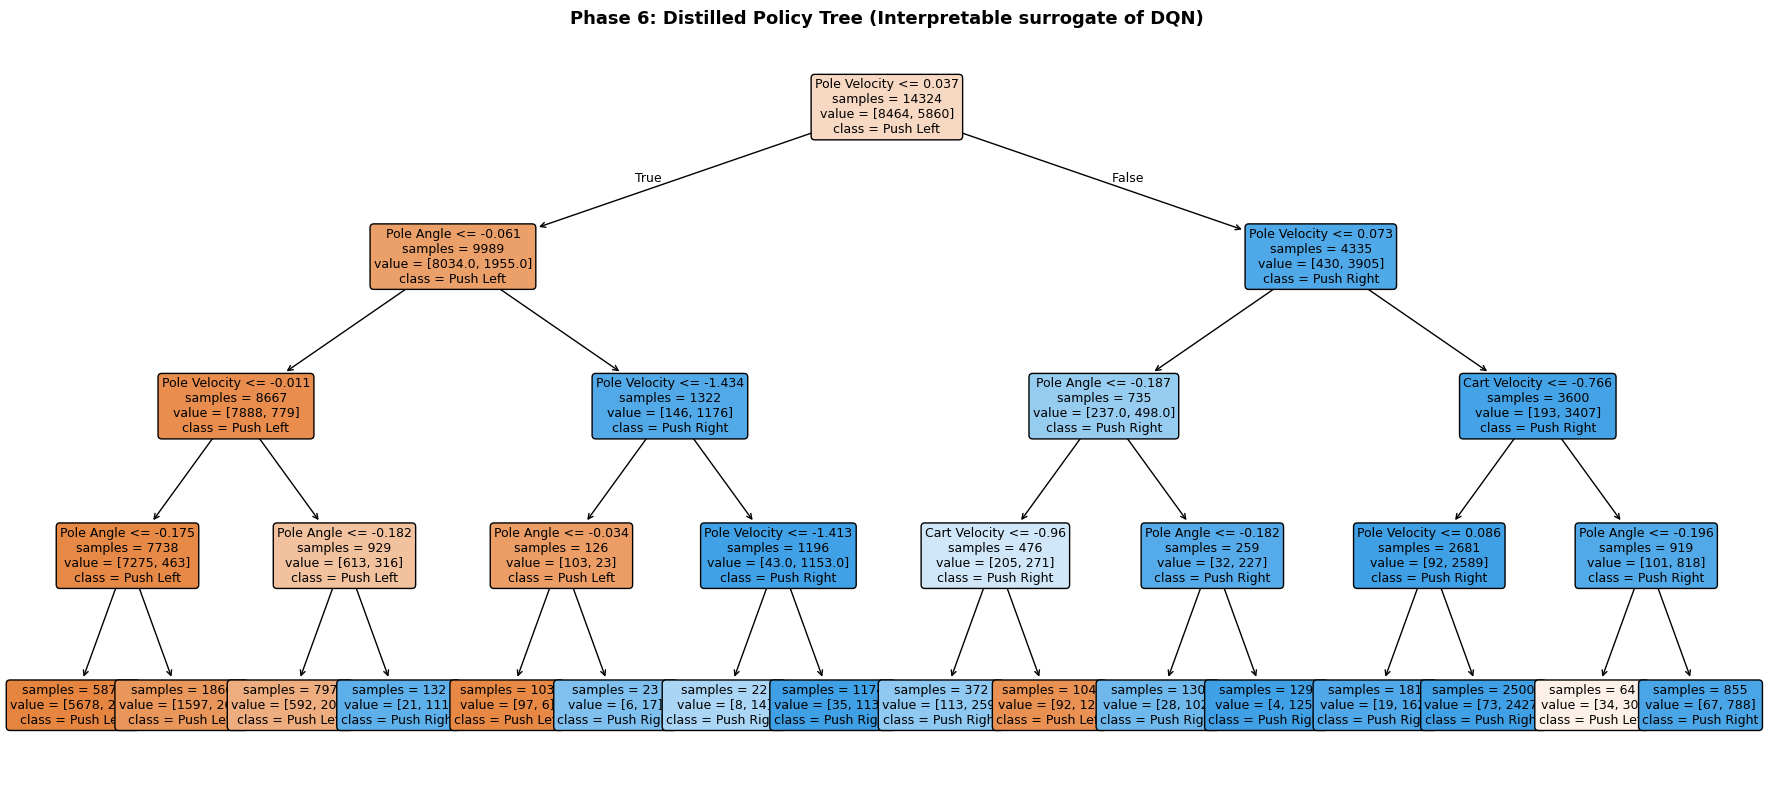


Human-Readable Rules:
|--- Pole Velocity <= 0.04
|   |--- Pole Angle <= -0.06
|   |   |--- Pole Velocity <= -0.01
|   |   |   |--- Pole Angle <= -0.17
|   |   |   |   |--- class: 0
|   |   |   |--- Pole Angle >  -0.17
|   |   |   |   |--- class: 0
|   |   |--- Pole Velocity >  -0.01
|   |   |   |--- Pole Angle <= -0.18
|   |   |   |   |--- class: 0
|   |   |   |--- Pole Angle >  -0.18
|   |   |   |   |--- class: 1
|   |--- Pole Angle >  -0.06
|   |   |--- Pole Velocity <= -1.43
|   |   |   |--- Pole Angle <= -0.03
|   |   |   |   |--- class: 0
|   |   |   |--- Pole Angle >  -0.03
|   |   |   |   |--- class: 1
|   |   |--- Pole Velocity >  -1.43
|   |   |   |--- Pole Velocity <= -1.41
|   |   |   |   |--- class: 1
|   |   |   |--- Pole Velocity >  -1.41
|   |   |   |   |--- class: 1
|--- Pole Velocity >  0.04
|   |--- Pole Velocity <= 0.07
|   |   |--- Pole Angle <= -0.19
|   |   |   |--- Cart Velocity <= -0.96
|   |   |   |   |--- class: 1
|   |   |   |--- Cart Velocity >  -0.96
|   |

In [11]:
print('Collecting distillation data...')
env_d = SafeCartPoleEnv()
X_data, y_data = [], []
for ep in trange(300, desc='Distillation data'):
    obs,_ = env_d.reset(seed=ep); done=False
    while not done:
        X_data.append(obs.copy())
        a = dqn_agent.act(obs)
        y_data.append(a)
        obs,_,t,tr,_ = env_d.step(a); done=t or tr
env_d.close()

X = np.array(X_data, dtype=np.float32)
y = np.array(y_data)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f'Dataset: {len(X):,} samples')

depths = [2, 3, 4, 5, 6, 8]
accs   = []
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=SEED)
    dt.fit(X_tr, y_tr)
    accs.append(accuracy_score(y_te, dt.predict(X_te)))

plt.figure(figsize=(9,4))
plt.plot(depths, [a*100 for a in accs], 'o-', color='teal', lw=2, ms=8)
plt.axhline(95, color='steelblue', ls='--', alpha=0.6, label='95% threshold')
plt.xlabel('Decision Tree Max Depth', fontsize=12)
plt.ylabel('Fidelity to DNN Policy (%)', fontsize=12)
plt.title('Policy Distillation: Fidelity vs. Complexity', fontsize=13, fontweight='bold')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

best_dt = DecisionTreeClassifier(max_depth=4, random_state=SEED)
best_dt.fit(X_tr, y_tr)
print(f'Depth-4 tree fidelity: {accuracy_score(y_te, best_dt.predict(X_te))*100:.1f}%')

fig, ax = plt.subplots(figsize=(18,8))
plot_tree(best_dt, feature_names=feature_names,
          class_names=['Push Left','Push Right'],
          filled=True, rounded=True, fontsize=9, ax=ax, impurity=False)
ax.set_title('Phase 6: Distilled Policy Tree (Interpretable surrogate of DQN)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('policy_tree.png', dpi=130, bbox_inches='tight')
plt.show()

print('\nHuman-Readable Rules:')
print('='*55)
print(export_text(best_dt, feature_names=feature_names)[:1200])


## Section 10: Comparison Dashboard — All Three Agents


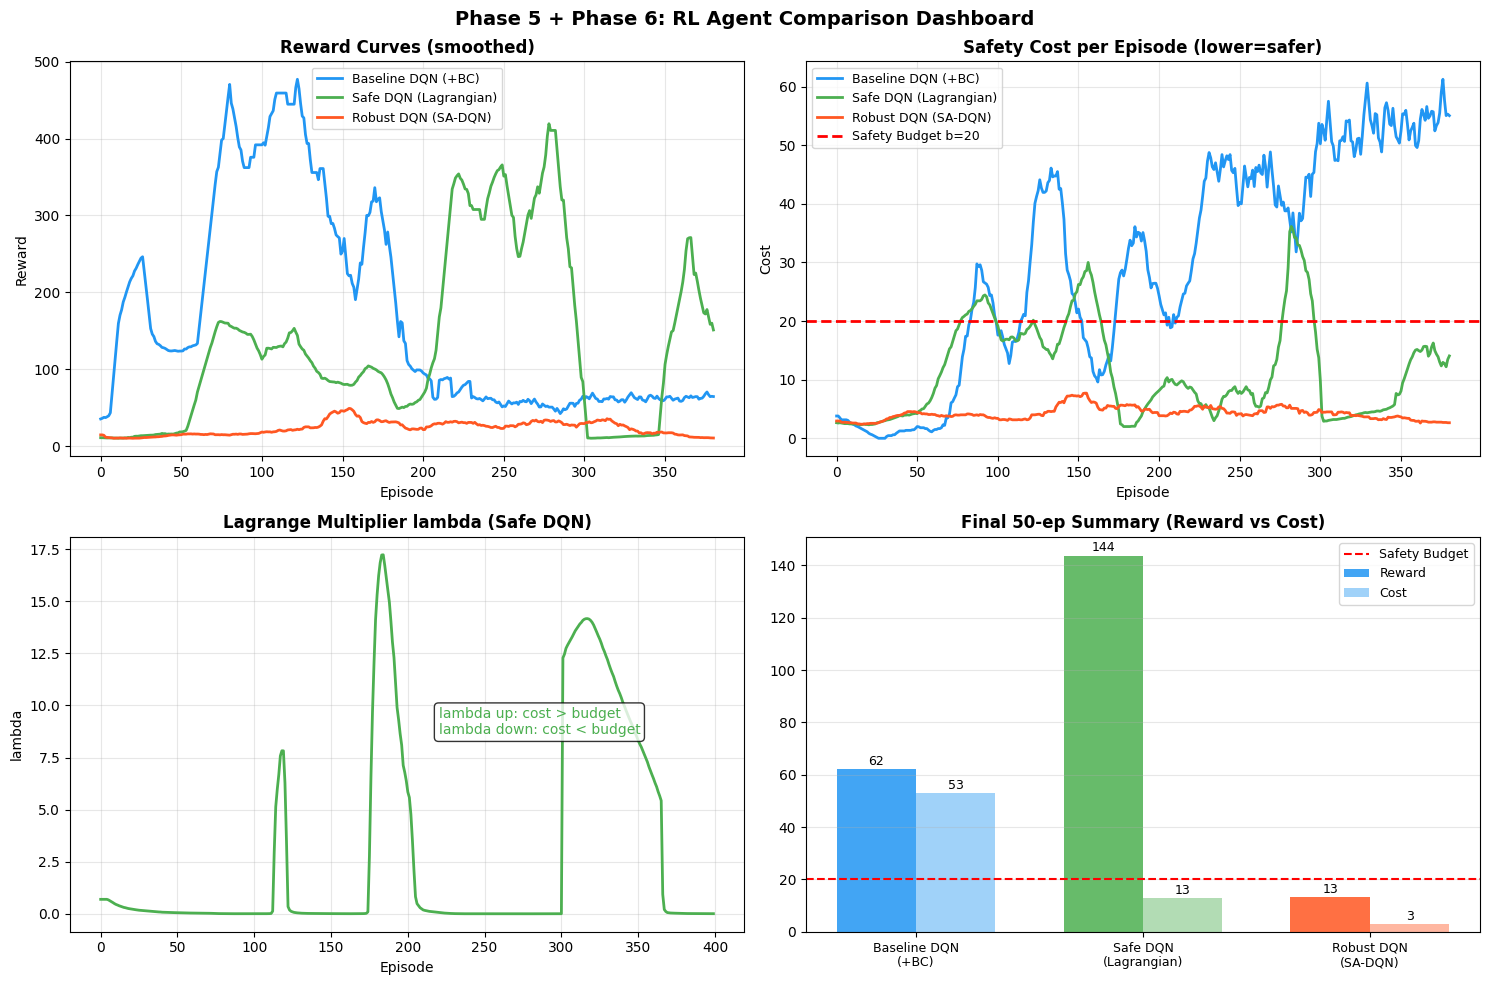

Dashboard saved!


In [12]:
def smooth(v, w=20):
    return np.convolve(v, np.ones(w)/w, mode='valid') if len(v)>=w else v


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Phase 5 + Phase 6: RL Agent Comparison Dashboard',
             fontsize=14, fontweight='bold')

pairs = [('Baseline DQN (+BC)', dqn_rewards,    dqn_costs,    '#2196F3'),
         ('Safe DQN (Lagrangian)', safe_rewards, safe_costs,   '#4CAF50'),
         ('Robust DQN (SA-DQN)', robust_rewards, robust_costs, '#FF5722')]

ax = axes[0,0]
for lbl,rews,_,col in pairs:
    s = smooth(rews); ax.plot(range(len(s)), s, label=lbl, color=col, lw=2)
ax.set_title('Reward Curves (smoothed)', fontweight='bold')
ax.set_xlabel('Episode'); ax.set_ylabel('Reward')
ax.legend(fontsize=9); ax.grid(alpha=0.3)

ax = axes[0,1]
for lbl,_,costs,col in pairs:
    s = smooth(costs); ax.plot(range(len(s)), s, label=lbl, color=col, lw=2)
ax.axhline(20, color='red', ls='--', lw=2, label='Safety Budget b=20')
ax.set_title('Safety Cost per Episode (lower=safer)', fontweight='bold')
ax.set_xlabel('Episode'); ax.set_ylabel('Cost')
ax.legend(fontsize=9); ax.grid(alpha=0.3)

ax = axes[1,0]
ax.plot(lambdas, color='#4CAF50', lw=2)
ax.set_title('Lagrange Multiplier lambda (Safe DQN)', fontweight='bold')
ax.set_xlabel('Episode'); ax.set_ylabel('lambda')
ax.text(len(lambdas)*0.55, max(lambdas)*0.5,
        'lambda up: cost > budget\nlambda down: cost < budget',
        fontsize=10, color='#4CAF50',
        bbox=dict(boxstyle='round', fc='white', alpha=0.8))
ax.grid(alpha=0.3)

ax = axes[1,1]
agents = ['Baseline DQN\n(+BC)', 'Safe DQN\n(Lagrangian)', 'Robust DQN\n(SA-DQN)']
rm = [np.mean(dqn_rewards[-50:]), np.mean(safe_rewards[-50:]), np.mean(robust_rewards[-50:])]
cm = [np.mean(dqn_costs[-50:]),   np.mean(safe_costs[-50:]),   np.mean(robust_costs[-50:])]
x = np.arange(3); w=0.35
b1=ax.bar(x-w/2, rm, w, color=['#2196F3','#4CAF50','#FF5722'], alpha=0.85, label='Reward')
b2=ax.bar(x+w/2, cm, w, color=['#90CAF9','#A5D6A7','#FFAB91'], alpha=0.85, label='Cost')
ax.axhline(20, color='red', ls='--', lw=1.5, label='Safety Budget')
for b in list(b1)+list(b2):
    ax.text(b.get_x()+b.get_width()/2., b.get_height()+0.5,
            f'{b.get_height():.0f}', ha='center', va='bottom', fontsize=9)
ax.set_xticks(x); ax.set_xticklabels(agents, fontsize=9)
ax.set_title('Final 50-ep Summary (Reward vs Cost)', fontweight='bold')
ax.legend(fontsize=9); ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_dashboard.png', dpi=130, bbox_inches='tight')
plt.show()
print('Dashboard saved!')


## Section 11: Robustness Evaluation — Stress Test Under Noise


Evaluating robustness under observation noise...


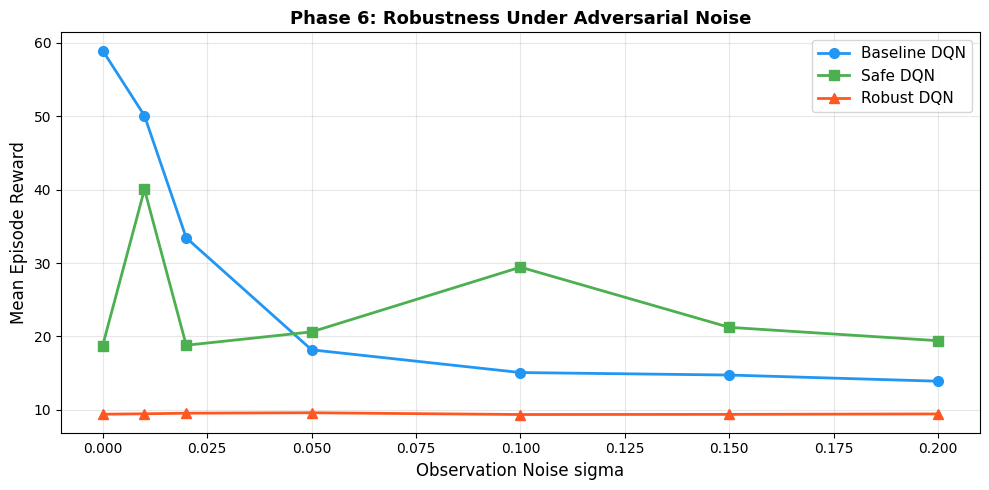

At sigma=0.1 -> DQN:15  Safe:29  Robust:9


In [13]:
def eval_noise(agent, noise_levels, n_eps=50):
    results = []
    for noise in noise_levels:
        env = SafeCartPoleEnv(noise_std=noise)
        ep_rews = []
        for ep in range(n_eps):
            obs,_ = env.reset(seed=ep); done,ep_r = False, 0
            while not done:
                obs,r,t,tr,_ = env.step(agent.act(obs)); done=t or tr; ep_r+=r
            ep_rews.append(ep_r)
        env.close()
        results.append(np.mean(ep_rews))
    return results


noise_levels = [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
print('Evaluating robustness under observation noise...')
dqn_noise    = eval_noise(dqn_agent, noise_levels)
robust_noise = eval_noise(robust_agent, noise_levels)
safe_noise   = eval_noise(safe_agent, noise_levels)

plt.figure(figsize=(10,5))
plt.plot(noise_levels, dqn_noise,    'o-', color='#2196F3', lw=2, ms=7, label='Baseline DQN')
plt.plot(noise_levels, safe_noise,   's-', color='#4CAF50', lw=2, ms=7, label='Safe DQN')
plt.plot(noise_levels, robust_noise, '^-', color='#FF5722', lw=2, ms=7, label='Robust DQN')
plt.xlabel('Observation Noise sigma', fontsize=12)
plt.ylabel('Mean Episode Reward', fontsize=12)
plt.title('Phase 6: Robustness Under Adversarial Noise', fontsize=13, fontweight='bold')
plt.legend(fontsize=11); plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('robustness_eval.png', dpi=130)
plt.show()
print(f'At sigma=0.1 -> DQN:{dqn_noise[4]:.0f}  Safe:{safe_noise[4]:.0f}  Robust:{robust_noise[4]:.0f}')


## Section 12: Project Summary & Key Takeaways

| Agent | Method | Phase | Key Benefit |
|-------|--------|-------|-------------|
| Baseline DQN | DQN + Behaviour Cloning | Phase 5 | Fast start via offline pre-training |
| Safe DQN | Lagrangian CMDP | Phase 6 | Stays within safety budget |
| Robust DQN | SA-DQN / FGSM training | Phase 6 | Resilient to observation noise |

### Takeaways

**Phase 5 (Offline RL):**
- Behaviour Cloning pre-training jumpstarts learning from logged data
- Avoids random exploration and speeds up convergence significantly

**Phase 6 - Safety:**
- Lambda automatically adapts to enforce the cost constraint J^c <= b
- Dual Q-heads (reward + cost) are the core of CMDP training

**Phase 6 - Robustness:**
- FGSM adversarial training with robustness regularisation improves noise resilience
- Essential for deployment where sensors have noise or adversaries exist

**Phase 6 - Explainability:**
- SHAP reveals Pole Angle as the dominant decision feature (as expected)
- Decision tree distillation produces auditable IF-THEN rules

---

**Follow the RL Roadmap Series:**  
LinkedIn: [linkedin.com/in/abdullahzahid655](https://linkedin.com/in/abdullahzahid655)  
GitHub: [github.com/abdullahzahid655](https://github.com/abdullahzahid655)  

*Next: Phase 7 - Model-Based RL & World Models!*
